# Spotify Playlist Personalisation

----

### 1. Set Environmental variables

Use auth_example.env as a sample. Provide all 3 secrets set in your spotify developer platform

* SPOTIFY_CLIENT_ID=
* SPOTIFY_CLIENT_SECRET=
* SPOTIFY_REDIRECT_URI=


In [1]:
from dotenv import load_dotenv

# Load .env file
load_dotenv()


True

### 2. Generate Token
Provide call back link to generate token for use

In [2]:
import tekore as tk
conf = tk.config_from_environment()
token = tk.prompt_for_user_token(*conf)


Opening browser for Spotify login...


### 3. Retrieving Playlist & Track Data

Reference util.py for additional functionality for data pull.

Utilising tekore package to interact with Spotify API.


In [193]:
from util import *
import asyncio
import pandas as pd

async_spotify = tk.Spotify(token = token, asynchronous=True)
uri = 'spotify:user:gingerale3'
userID = 'gingerale3'

In [194]:
a = await fetch_playlists(async_spotify, userID)

In [206]:
playlist_ids = []
for i, playlist in enumerate(a):
    if playlist.owner.uri != uri:
        continue
    playlist_ids.append((playlist.id, playlist.name))

In [196]:
async def get_playlist_tracks_ids(spotify, playlistID: str, playlistName: str):
    playlistTracks = []
    inital_response = await spotify.playlist_items(playlistID, limit = 1, offset = 0)
    total = inital_response.total 
    playlistTracks.extend({"playlistID": playlistID, "name": playlistName, "track": item} for item in inital_response.items)
    limit = 50
    numOfCalls = (total - 1)//limit + 1

    tasks = [spotify.playlist_items(playlistID, limit = limit, offset = 1 + limit * i) for i in range(numOfCalls)]
    responses = await asyncio.gather(*tasks)
    for response in responses:
        playlistTracks.extend({"playlistID": playlistID, "name": playlistName, "track": item} for item in response.items)

    return playlistTracks


In [207]:
playlistTracks = []
for i in range(len(playlist_ids)//3 + 1):
    tasks = [get_playlist_tracks_ids(async_spotify, id[0], id[1]) for id in playlist_ids[i*3:(i+1)*3]]
    responses = await asyncio.gather(*tasks)
    for response in responses:
        playlistTracks.extend(response)

In [208]:
len(playlistTracks)

1998

In [209]:
# Track id and corresponding playlist
trackId_playlist = []

for tracks in playlistTracks:
    if tracks['track'].track.id is None:
        continue
    trackId_playlist.append({
        'playlistID': tracks['playlistID'],
        'playlistName': tracks['name'],
        'id': tracks['track'].track.id,
        'trackName': tracks['track'].track.name,
        'trackArtist': [artist.name for artist in tracks['track'].track.artists]
        }
    )

In [210]:
len(set([(tracks['playlistID'], tracks['track'].track.id)  for tracks in playlistTracks]))

1995

In [211]:
# Get all features for tracks
track_features = await get_tracks_audio_features(async_spotify, tracks = [track['id'] for track in trackId_playlist])
track_features = [track.__dict__ for track in track_features if track is not None]
track_features_df = pd.DataFrame(track_features).drop_duplicates()
df = pd.DataFrame(trackId_playlist).merge(track_features_df, on = 'id', how = 'left')


In [212]:
# Add description playlist descriptions
len(playlist_ids)

19

In [213]:
# Create consolidate dataframe

In [214]:
features = [
    'acousticness', 
    'danceability',
    'energy',
    'instrumentalness',
    # 'key',
    'liveness',
    # 'loudness',
    # 'mode',
    'speechiness',
    # 'tempo',
    # 'time_signature',
    'valence'
]

df_clean = df.dropna(subset=features)

# ### What if i scaled the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_clean[features] = scaler.fit_transform(df_clean[features])

c:\Users\alexc\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### Modelling

3 Steps
* Feature extraction (can be expanded with more features). But for now lets use spotifys default features
* Clustering/classification
    *  For now lets use k means (see how can we decide how many clusters)
* Natural language generation
    * We'll construct a template for each label or category (as we get more data)
    * Can evolve using a transformer or LLM trained on a relevant dataset(this/template)




Note:

Chose to cluster tracks before giving a label. Becomes from TSNE graphical nature it was clear my playlists do vary within myself. Which aligns with my assumption.
Hence for now - perform clustering. Label the following clusters.

Can look to evolve each step


### K means clustering + Elbow/Silhouette Method

In [215]:
# Reduce Dataset to just values
X = df_clean[features].values


Based of the graphs below, going for 9 clusters

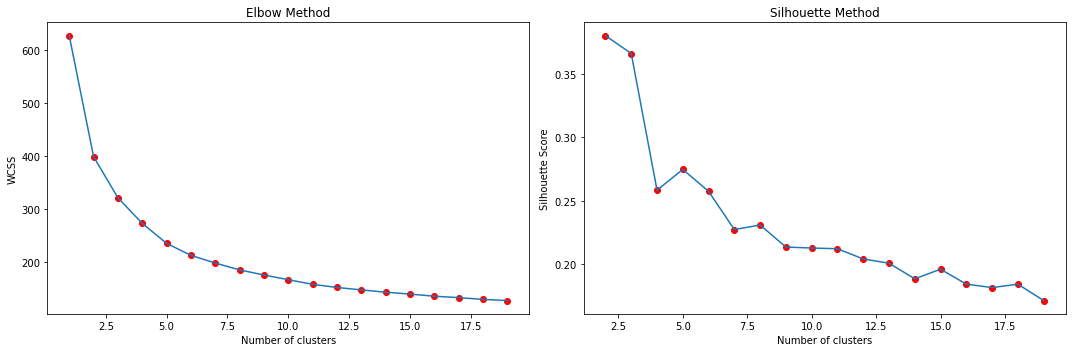

In [216]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

wcss = [] # Within-Cluster Sum of Square
silhouette_scores = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state = 16).fit(X)
    #Elbow Method
    wcss.append(kmeans.inertia_)

    #Silhouette
    if i >= 2: #Requires two samples
        label = kmeans.labels_
        sil_coeff = silhouette_score(X, label, metric='euclidean')
        silhouette_scores.append(sil_coeff)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(1, 20), wcss)
axs[0].scatter(range(1, 20), wcss, color='red')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')
# plt.show()



axs[1].plot(range(2, 20), silhouette_scores)
axs[1].scatter(range(2, 20), silhouette_scores, color='red')
axs[1].set_title('Silhouette Method')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')
# plt.show()

plt.tight_layout()
plt.show()


### Chosen algo and hyperparameter


In [217]:
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=1000, n_init=10, random_state = 16).fit(X)
df_clean['kmeans_cluster'] = kmeans.labels_ ## Adding k means cluster to original dataset

<ipython-input-217-9470275ac676>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['kmeans_cluster'] = kmeans.labels_ ## Adding k means cluster to original dataset


### Visualising/Describing each cluster

##### Adding TSNE to visualise cluster across two dimensions

In [218]:
from sklearn.manifold import TSNE

# Extract the features from the dataframe
data_subset = df_clean[features].values

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state = 27)
tsne_results = tsne.fit_transform(data_subset)

# Add the t-SNE results back into the dataframe
df_clean['tsne-2d-one'] = tsne_results[:,0]
df_clean['tsne-2d-two'] = tsne_results[:,1]



<ipython-input-218-c1c884a0b5f3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tsne-2d-one'] = tsne_results[:,0]
<ipython-input-218-c1c884a0b5f3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tsne-2d-two'] = tsne_results[:,1]


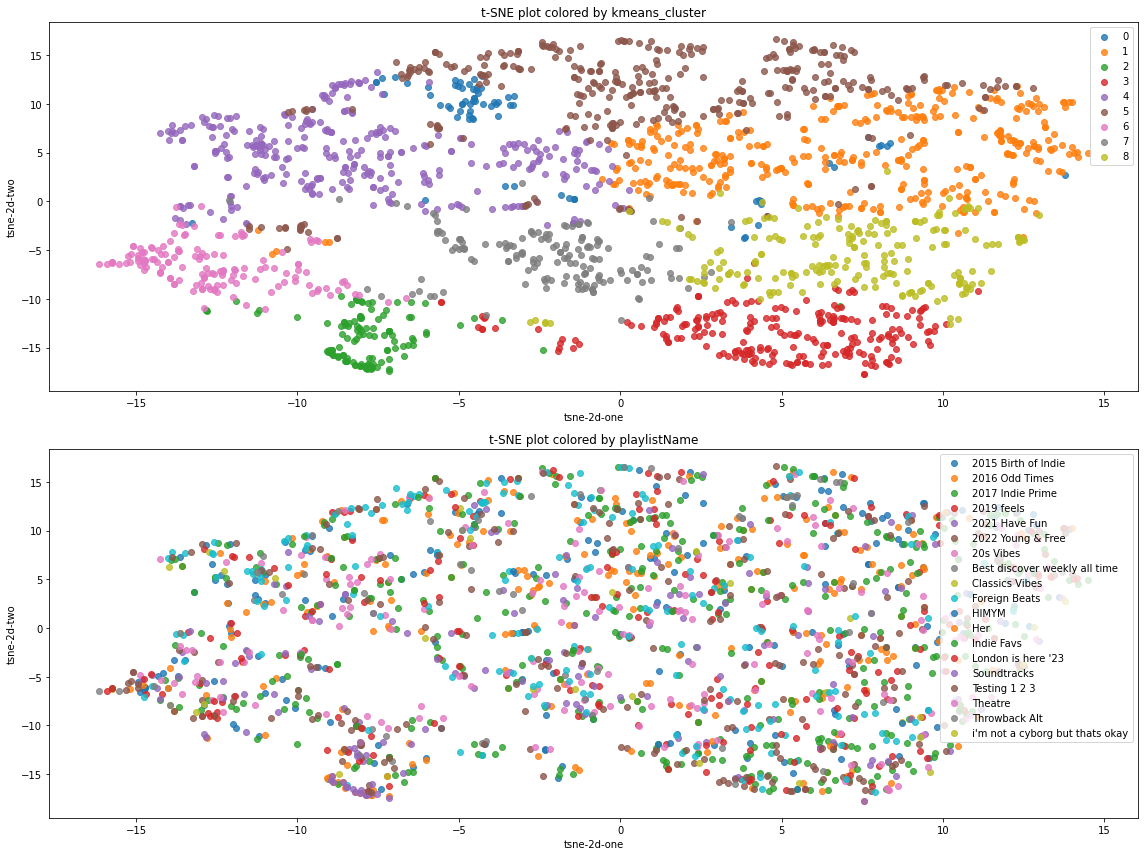

In [219]:
# Set plot size
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

# Create a plot

# Scatter plot for each playlist
for cluster, group in df_clean.groupby('kmeans_cluster'):
    axs[0].scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.8, label=cluster)

axs[0].legend()
axs[0].set_title('t-SNE plot colored by kmeans_cluster')
axs[0].set_xlabel('tsne-2d-one')
axs[0].set_ylabel('tsne-2d-two')



## Plalist
for playlist, group in df_clean.groupby('playlistName'):
    axs[1].scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.8, label=playlist)

axs[1].legend(loc = 'upper right')
axs[1].set_title('t-SNE plot colored by playlistName')
axs[1].set_xlabel('tsne-2d-one')
axs[1].set_ylabel('tsne-2d-two')


plt.tight_layout()
plt.show()





### Worded template for each cluster

As we continue to evolve for the future and potential LLM use. For now using my knowledge of my playlist I will classify and describe each cluster

- 0: "Featuring a slow tempo but compelling rhythm, this song invites you to sway along, albeit with a tinge of sadness or anger. It's a heartfelt narrative wrapped in danceable beats, suitable for moments when you want to dance away your blues."
- 1 "This playlist is rich in emotional depth. With low energy and a sober tone, it offers a contemplative musical experience, ideal for moments of quiet introspection, late-night thoughts."
- 2: "Absolute banger with electrifying, high-energy beats that'll compel you to move your feet. It carries a contagious positive atmosphere, spreading euphoria and joy with each beat. Perfect for parties, gatherings, or when you just need a pick-me-up."
- 3: "Strikes a balance between energy and danceability, making it versatile for various moods and settings. Depending on the emotional tone—be it happiness, melancholy, anger, or euphoria—it can serve as a fitting playlist for a quiet evening, a casual gathering, or introspective moments"
- 4: "For those drives home when you are in a melancholic mood" 
- 5: "Playlist with an electrifying, high-energy beat that'll compel you to move your feet. It carries a contagious positive atmosphere, spreading euphoria and joy with each beat. Perfect for parties, gatherings, or when you just need a pick-me-up."
- 6: "Lofi and sombre tone. Embrace the contemplative experience"
- 7: "A gentle head bouncing inducing playlist. For those afternoon walks."
- 8: "An indie rock experience"

Understanding features further

For all Spotify tracks - you can retrieve it’s features. Deeper information can be found https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

- Features to be mapped
    - Acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
    - Danceability: A value of 0.0 is least danceable and 1.0 is most danceable.
    - Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
    - Instrumentalness: Predicts whether a track contains no vocals.
    - Liveness: Higher liveness values represent an increased probability that the track was performed live
    - Spechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value
    - Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

#### Saving model for serving

* Model to assign cluster 1-8
* Json to match current cluster to generic template

In [248]:
df_clean.loc[df_clean.kmeans_cluster == 6].head(-20)

,playlistID,playlistName,id,trackName,trackArtist,acousticness,analysis_url,danceability,duration_ms,energy,...,speechiness,tempo,time_signature,track_href,type,uri,valence,kmeans_cluster,tsne-2d-one,tsne-2d-two
12,1M14Pc0M9RCNTeiGZYkRos,London is here '23,1I9CYgnoP99PAgTqkPPO4o,Wait for Something Better,[PROM],0.117468,https://api.spotify.com/v1/audio-analysis/1I9C...,0.730689,192000.0,0.609941,...,0.032581,109.981,4.0,https://api.spotify.com/v1/tracks/1I9CYgnoP99P...,audio_features,spotify:track:1I9CYgnoP99PAgTqkPPO4o,0.196118,6,-11.923998,-7.009821
15,1M14Pc0M9RCNTeiGZYkRos,London is here '23,1zVdtLGr29KT5pCNOFM6Ko,FIGHT,[IAN SWEET],0.001283,https://api.spotify.com/v1/audio-analysis/1zVd...,0.457203,212027.0,0.551179,...,0.036237,79.080,4.0,https://api.spotify.com/v1/tracks/1zVdtLGr29KT...,audio_features,spotify:track:1zVdtLGr29KT5pCNOFM6Ko,0.210419,6,-12.589305,-7.439512
24,1M14Pc0M9RCNTeiGZYkRos,London is here '23,6saLahiLYYPH5yHLuGNnB5,I'm With You,[No Buses],0.222890,https://api.spotify.com/v1/audio-analysis/6saL...,0.598121,185292.0,0.856134,...,0.029032,88.522,4.0,https://api.spotify.com/v1/tracks/6saLahiLYYPH...,audio_features,spotify:track:6saLahiLYYPH5yHLuGNnB5,0.577120,6,-14.763578,-5.226719
29,1M14Pc0M9RCNTeiGZYkRos,London is here '23,2vdBqxmJINmqCR28nMrCHf,flowers,[vhs sports],0.602409,https://api.spotify.com/v1/audio-analysis/2vdB...,0.608559,167500.0,0.898686,...,0.040753,120.004,4.0,https://api.spotify.com/v1/tracks/2vdBqxmJINmq...,audio_features,spotify:track:2vdBqxmJINmqCR28nMrCHf,0.685393,6,-8.745334,-9.131721
38,1M14Pc0M9RCNTeiGZYkRos,London is here '23,72cGBEqu7RitIOoACXYjfR,The Blonde,[TV Girl],0.225902,https://api.spotify.com/v1/audio-analysis/72cG...,0.522965,227760.0,0.553205,...,0.026129,87.692,4.0,https://api.spotify.com/v1/tracks/72cGBEqu7Rit...,audio_features,spotify:track:72cGBEqu7RitIOoACXYjfR,0.229826,6,-12.720242,-8.998802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,4xojdBtcHnIEzPlnoC0JOM,Throwback Alt,78lNo05zChrn0ukKahc8hT,Munich,[Editors],0.000315,https://api.spotify.com/v1/audio-analysis/78lN...,0.297495,310067.0,0.726452,...,0.044731,161.088,4.0,https://api.spotify.com/v1/tracks/78lNo05zChrn...,audio_features,spotify:track:78lNo05zChrn0ukKahc8hT,0.549540,6,-15.518360,-6.454010
1780,4xojdBtcHnIEzPlnoC0JOM,Throwback Alt,1XPta4VLT78HQnVFd1hlsK,Today,[The Smashing Pumpkins],0.000024,https://api.spotify.com/v1/audio-analysis/1XPt...,0.496868,202133.0,0.865252,...,0.028495,82.955,4.0,https://api.spotify.com/v1/tracks/1XPta4VLT78H...,audio_features,spotify:track:1XPta4VLT78HQnVFd1hlsK,0.416752,6,-14.432112,-5.956774
1781,4xojdBtcHnIEzPlnoC0JOM,Throwback Alt,4iCGSi1RonREsPtfEKYj5b,"Tonight, Tonight - Remastered 2012",[The Smashing Pumpkins],0.000061,https://api.spotify.com/v1/audio-analysis/4iCG...,0.289144,254627.0,0.677821,...,0.040430,148.342,4.0,https://api.spotify.com/v1/tracks/4iCGSi1RonRE...,audio_features,spotify:track:4iCGSi1RonREsPtfEKYj5b,0.221655,6,-13.947928,-7.857481
1795,4xojdBtcHnIEzPlnoC0JOM,Throwback Alt,7E99aG3oPQslXHHdnKFAmB,Game Of Pricks,[Guided By Voices],0.248995,https://api.spotify.com/v1/audio-analysis/7E99...,0.384134,93307.0,0.977711,...,0.078495,122.243,4.0,https://api.spotify.com/v1/tracks/7E99aG3oPQsl...,audio_features,spotify:track:7E99aG3oPQslXHHdnKFAmB,0.329928,6,-16.154354,-6.461644


In [221]:
from joblib import dump

# assuming kmeans is your trained model
dump(kmeans, 'kmeans.joblib') 

['kmeans.joblib']

In [250]:
import json
json_template = {
    0: "Playlist with an electrifying, high-energy beat that'll compel you to move your feet. It carries a contagious positive atmosphere, spreading euphoria and joy with each beat. Perfect for parties, gatherings, or when you just need a pick-me-up.",
    1: "Featuring a slow tempo but compelling rhythm, this song invites you to sway along, albeit with a tinge of sadness or anger. It's a heartfelt narrative wrapped in danceable beats, suitable for moments when you want to dance away your blues.",
    2: "Lofi and sombre tone. Embrace the contemplative experience",
    3: "This playlist is rich in emotional depth. With low energy and a sober tone, it offers a contemplative musical experience, ideal for moments of quiet introspection, late-night thoughts.",
    4: "Strikes a balance between energy and danceability, making it versatile for various moods and settings. Depending on the emotional tone—be it happiness, melancholy, anger, or euphoria—it can serve as a fitting playlist for a quiet evening, a casual gathering, or introspective moments",
    5: "An indie rock experience",
    6: "For those drives home when you are in a melancholic mood",
    7: "Absolute banger with electrifying, high-energy beats that'll compel you to move your feet. It carries a contagious positive atmosphere, spreading euphoria and joy with each beat. Perfect for parties, gatherings, or when you just need a pick-me-up.",
    8: "A gentle head bouncing inducing playlist. For those afternoon walks.",
}

with open("cluster_template.json", "w") as outfile:
    json.dump(json_template, outfile)

### Scoring sample playlist and attach message
1. Import model and template
2. Pull playlist data
3. Get the mean score for all 7 features
4. Classify based off model and provide template

In [254]:
# e.g. Pipeline

from joblib import dump, load
import numpy as np

# 1. Load model

model = load("kmeans.joblib")
template = json.load(open('cluster_template.json'))

# 2. Pull playlist data and features
sample_playlist = await get_playlist_tracks_ids(async_spotify, playlist_ids[4][0], playlist_ids[4][1])

# Track id and corresponding playlist
sample_playlist_ids = []

for tracks in sample_playlist:
    if tracks['track'].track.id is None:
        continue
    sample_playlist_ids.append({
        'playlistID': tracks['playlistID'],
        'playlistName': tracks['name'],
        'id': tracks['track'].track.id,
        'trackName': tracks['track'].track.name,
        'trackArtist': [artist.name for artist in tracks['track'].track.artists]
        }
    )


# Get all data for tracks
sample_features = await get_tracks_audio_features(async_spotify, tracks = [track['id'] for track in sample_playlist_ids])
sample_features = [track.__dict__ for track in sample_features if track is not None]
sample_features_df = pd.DataFrame(sample_features).drop_duplicates()
sample_df = pd.DataFrame(sample_playlist_ids).merge(sample_features_df, on = 'id', how = 'left')
sample_df.dropna(inplace = True)

# Only features
sampleX = np.array(sample_df[features].values)

# 3. Predict/classify


predictOutput = model.predict(sampleX)
counts = np.bincount(predictOutput)
most_common_element = np.argmax(counts)
print("The most common element is:", most_common_element)
print("Associated template:", template[str(most_common_element)])


The most common element is: 2
Associated template: Lofi and sombre tone. Embrace the contemplative experience
